# Imports

In [1]:
import requests
from PIL import Image
import matplotlib.pyplot as plt

from transformers import CLIPImageProcessor, AutoTokenizer

import torch

# CLIP implem

In [2]:
# adapted from https://github.com/huggingface/transformers/blob/f4fc42216cd56ab6b68270bf80d811614d8d59e4/src/transformers/models/clip/modeling_clip.py#L860

from dataclasses import dataclass
from typing import Any, Callable, Optional, Tuple, Union

import torch
from torch import nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

from transformers.activations import ACT2FN
from transformers.modeling_attn_mask_utils import _create_4d_causal_attention_mask, _prepare_4d_attention_mask
from transformers.modeling_outputs import BaseModelOutput, BaseModelOutputWithPooling, ImageClassifierOutput
from transformers.modeling_utils import ALL_ATTENTION_FUNCTIONS, PreTrainedModel
from transformers.utils import ModelOutput, can_return_tuple, logging, torch_int
from transformers.models.clip.configuration_clip import CLIPConfig, CLIPTextConfig, CLIPVisionConfig


@dataclass
class CLIPVisionModelOutput(ModelOutput):
    """
    Base class for vision model's outputs that also contains image embeddings of the pooling of the last hidden states.

    Args:
        image_embeds (`torch.FloatTensor` of shape `(batch_size, output_dim)` *optional* returned when model is initialized with `with_projection=True`):
            The image embeddings obtained by applying the projection layer to the pooler_output.
        last_hidden_state (`torch.FloatTensor` of shape `(batch_size, sequence_length, hidden_size)`):
            Sequence of hidden-states at the output of the last layer of the model.
        hidden_states (`tuple(torch.FloatTensor)`, *optional*, returned when `output_hidden_states=True` is passed or when `config.output_hidden_states=True`):
            Tuple of `torch.FloatTensor` (one for the output of the embeddings, if the model has an embedding layer, +
            one for the output of each layer) of shape `(batch_size, sequence_length, hidden_size)`.

            Hidden-states of the model at the output of each layer plus the optional initial embedding outputs.
        attentions (`tuple(torch.FloatTensor)`, *optional*, returned when `output_attentions=True` is passed or when `config.output_attentions=True`):
            Tuple of `torch.FloatTensor` (one for each layer) of shape `(batch_size, num_heads, sequence_length,
            sequence_length)`.

            Attentions weights after the attention softmax, used to compute the weighted average in the self-attention
            heads.
    """

    image_embeds: Optional[torch.FloatTensor] = None
    last_hidden_state: Optional[torch.FloatTensor] = None
    hidden_states: Optional[Tuple[torch.FloatTensor, ...]] = None
    attentions: Optional[Tuple[torch.FloatTensor, ...]] = None


@dataclass
class CLIPTextModelOutput(ModelOutput):
    """
    Base class for text model's outputs that also contains a pooling of the last hidden states.

    Args:
        text_embeds (`torch.FloatTensor` of shape `(batch_size, output_dim)` *optional* returned when model is initialized with `with_projection=True`):
            The text embeddings obtained by applying the projection layer to the pooler_output.
        last_hidden_state (`torch.FloatTensor` of shape `(batch_size, sequence_length, hidden_size)`):
            Sequence of hidden-states at the output of the last layer of the model.
        hidden_states (`tuple(torch.FloatTensor)`, *optional*, returned when `output_hidden_states=True` is passed or when `config.output_hidden_states=True`):
            Tuple of `torch.FloatTensor` (one for the output of the embeddings, if the model has an embedding layer, +
            one for the output of each layer) of shape `(batch_size, sequence_length, hidden_size)`.

            Hidden-states of the model at the output of each layer plus the optional initial embedding outputs.
        attentions (`tuple(torch.FloatTensor)`, *optional*, returned when `output_attentions=True` is passed or when `config.output_attentions=True`):
            Tuple of `torch.FloatTensor` (one for each layer) of shape `(batch_size, num_heads, sequence_length,
            sequence_length)`.

            Attentions weights after the attention softmax, used to compute the weighted average in the self-attention
            heads.
    """

    text_embeds: Optional[torch.FloatTensor] = None
    last_hidden_state: Optional[torch.FloatTensor] = None
    hidden_states: Optional[Tuple[torch.FloatTensor, ...]] = None
    attentions: Optional[Tuple[torch.FloatTensor, ...]] = None


class CLIPVisionEmbeddings(nn.Module):
    def __init__(self, config: CLIPVisionConfig):
        super().__init__()
        self.config = config
        self.embed_dim = config.hidden_size
        self.image_size = config.image_size
        self.patch_size = config.patch_size

        self.class_embedding = nn.Parameter(torch.randn(self.embed_dim))

        self.patch_embedding = nn.Conv2d(
            in_channels=config.num_channels,
            out_channels=self.embed_dim,
            kernel_size=self.patch_size,
            stride=self.patch_size,
            bias=False,
        )

        self.num_patches = (self.image_size // self.patch_size) ** 2
        self.num_positions = self.num_patches + 1
        self.position_embedding = nn.Embedding(self.num_positions, self.embed_dim)
        self.register_buffer("position_ids", torch.arange(self.num_positions).expand((1, -1)), persistent=False)

    def forward(self, pixel_values: torch.FloatTensor, interpolate_pos_encoding=False) -> torch.Tensor:
        batch_size, _, height, width = pixel_values.shape
        if not interpolate_pos_encoding and (height != self.image_size or width != self.image_size):
            raise ValueError(
                f"Input image size ({height}*{width}) doesn't match model ({self.image_size}*{self.image_size})."
            )
        target_dtype = self.patch_embedding.weight.dtype
        patch_embeds = self.patch_embedding(pixel_values.to(dtype=target_dtype))  # shape = [*, width, grid, grid]
        patch_embeds = patch_embeds.flatten(2).transpose(1, 2)

        class_embeds = self.class_embedding.expand(batch_size, 1, -1)
        embeddings = torch.cat([class_embeds, patch_embeds], dim=1)
        if interpolate_pos_encoding:
            embeddings = embeddings + self.interpolate_pos_encoding(embeddings, height, width)
        else:
            embeddings = embeddings + self.position_embedding(self.position_ids)
        return embeddings


class CLIPTextEmbeddings(nn.Module):
    def __init__(self, config: CLIPTextConfig):
        super().__init__()
        embed_dim = config.hidden_size

        self.token_embedding = nn.Embedding(config.vocab_size, embed_dim)
        self.position_embedding = nn.Embedding(config.max_position_embeddings, embed_dim)

        # position_ids (1, len position emb) is contiguous in memory and exported when serialized
        self.register_buffer(
            "position_ids", torch.arange(config.max_position_embeddings).expand((1, -1)), persistent=False
        )

    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
    ) -> torch.Tensor:
        seq_length = input_ids.shape[-1] if input_ids is not None else inputs_embeds.shape[-2]
        max_position_embedding = self.position_embedding.weight.shape[0]

        if seq_length > max_position_embedding:
            raise ValueError(
                f"Sequence length must be less than max_position_embeddings (got `sequence length`: "
                f"{seq_length} and max_position_embeddings: {max_position_embedding}"
            )

        if position_ids is None:
            position_ids = self.position_ids[:, :seq_length]

        if inputs_embeds is None:
            inputs_embeds = self.token_embedding(input_ids)

        position_embeddings = self.position_embedding(position_ids)
        embeddings = inputs_embeds + position_embeddings

        return embeddings


def eager_attention_forward(
    module: nn.Module,
    query: torch.Tensor,
    key: torch.Tensor,
    value: torch.Tensor,
    attention_mask: Optional[torch.Tensor],
    scaling: float,
    dropout: float = 0.0,
    output_attentions: bool = True,
    **kwargs,
):
    attn_weights = torch.matmul(query, key.transpose(-1, -2)) * scaling
    if attention_mask is not None:
        attn_weights = attn_weights + attention_mask
    attn_weights = nn.functional.softmax(attn_weights, dim=-1, dtype=torch.float32).to(query.dtype)
    attn_weights = nn.functional.dropout(attn_weights, p=dropout, training=module.training)

    attn_output = torch.matmul(attn_weights, value)
    attn_output = attn_output.transpose(1, 2).contiguous()
    if not output_attentions:
        attn_weights = None
    return attn_output, attn_weights


class CLIPAttention(nn.Module):
    """Multi-headed attention from 'Attention Is All You Need' paper"""

    def __init__(self, config: Union[CLIPVisionConfig, CLIPTextConfig]):
        super().__init__()
        self.config = config
        self.embed_dim = config.hidden_size
        self.num_heads = config.num_attention_heads
        self.head_dim = self.embed_dim // self.num_heads
        if self.head_dim * self.num_heads != self.embed_dim:
            raise ValueError(
                f"embed_dim must be divisible by num_heads (got `embed_dim`: {self.embed_dim} and `num_heads`:"
                f" {self.num_heads})."
            )
        self.scale = self.head_dim**-0.5
        self.dropout = config.attention_dropout
        self.is_causal = False

        self.k_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.v_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.q_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.out_proj = nn.Linear(self.embed_dim, self.embed_dim)

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        causal_attention_mask: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = False,
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        """Input shape: Batch x Time x Channel"""

        batch_size, seq_length, embed_dim = hidden_states.shape

        queries = self.q_proj(hidden_states)
        keys = self.k_proj(hidden_states)
        values = self.v_proj(hidden_states)

        queries = queries.view(batch_size, seq_length, -1, self.head_dim).transpose(1, 2)
        keys = keys.view(batch_size, seq_length, -1, self.head_dim).transpose(1, 2)
        values = values.view(batch_size, seq_length, -1, self.head_dim).transpose(1, 2)
        # CLIP text model uses both `causal_attention_mask` and `attention_mask`
        # in case FA2 kernel is called, `is_causal` should be inferred from `causal_attention_mask`
        if self.config._attn_implementation == "flash_attention_2":
            self.is_causal = causal_attention_mask is not None
        else:
            if attention_mask is not None and causal_attention_mask is not None:
                attention_mask = attention_mask + causal_attention_mask
            elif causal_attention_mask is not None:
                attention_mask = causal_attention_mask

        attention_interface: Callable = eager_attention_forward
        if self.config._attn_implementation != "eager":
            if self.config._attn_implementation == "sdpa" and output_attentions:
                logger.warning_once(
                    "`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to "
                    'eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.'
                )
            else:
                attention_interface = ALL_ATTENTION_FUNCTIONS[self.config._attn_implementation]

        attn_output, attn_weights = attention_interface(
            self,
            queries,
            keys,
            values,
            attention_mask,
            is_causal=self.is_causal,
            scaling=self.scale,
            dropout=0.0 if not self.training else self.dropout,
            output_attentions=output_attentions,
        )

        attn_output = attn_output.reshape(batch_size, seq_length, embed_dim).contiguous()
        attn_output = self.out_proj(attn_output)

        if not output_attentions:
            attn_weights = None
        return attn_output, attn_weights


class CLIPMLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.activation_fn = ACT2FN[config.hidden_act]
        self.fc1 = nn.Linear(config.hidden_size, config.intermediate_size)
        self.fc2 = nn.Linear(config.intermediate_size, config.hidden_size)

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        hidden_states = self.fc1(hidden_states)
        hidden_states = self.activation_fn(hidden_states)
        hidden_states = self.fc2(hidden_states)
        return hidden_states


class CLIPEncoderLayer(nn.Module):
    def __init__(self, config: Union[CLIPVisionConfig, CLIPTextConfig]):
        super().__init__()
        self.embed_dim = config.hidden_size
        self.self_attn = CLIPAttention(config)
        self.layer_norm1 = nn.LayerNorm(self.embed_dim, eps=config.layer_norm_eps)
        self.mlp = CLIPMLP(config)
        self.layer_norm2 = nn.LayerNorm(self.embed_dim, eps=config.layer_norm_eps)

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: torch.Tensor,
        causal_attention_mask: torch.Tensor,
        output_attentions: Optional[bool] = False,
    ) -> Tuple[torch.FloatTensor]:
        """
        Args:
            hidden_states (`torch.FloatTensor`): input to the layer of shape `(batch, seq_len, embed_dim)`
            attention_mask (`torch.FloatTensor`): attention mask of size
                `(batch, 1, tgt_len, src_len)` where padding elements are indicated by very large negative values.
                `(config.encoder_attention_heads,)`.
            output_attentions (`bool`, *optional*):
                Whether or not to return the attentions tensors of all attention layers. See `attentions` under
                returned tensors for more detail.
        """
        residual = hidden_states

        hidden_states = self.layer_norm1(hidden_states)
        hidden_states, attn_weights = self.self_attn(
            hidden_states=hidden_states,
            attention_mask=attention_mask,
            causal_attention_mask=causal_attention_mask,
            output_attentions=output_attentions,
        )
        hidden_states = residual + hidden_states

        residual = hidden_states
        hidden_states = self.layer_norm2(hidden_states)
        hidden_states = self.mlp(hidden_states)
        hidden_states = residual + hidden_states

        outputs = (hidden_states,)

        if output_attentions:
            outputs += (attn_weights,)

        return outputs


class CLIPPreTrainedModel(PreTrainedModel):
    config_class = CLIPConfig
    base_model_prefix = "clip"
    supports_gradient_checkpointing = True
    _supports_sdpa = True
    _supports_flash_attn_2 = True

    def _init_weights(self, module):
        """Initialize the weights"""
        factor = self.config.initializer_factor
        if isinstance(module, CLIPTextEmbeddings):
            module.token_embedding.weight.data.normal_(mean=0.0, std=factor * 0.02)
            module.position_embedding.weight.data.normal_(mean=0.0, std=factor * 0.02)
        elif isinstance(module, CLIPVisionEmbeddings):
            factor = self.config.initializer_factor
            nn.init.normal_(module.class_embedding, mean=0.0, std=module.embed_dim**-0.5 * factor)
            nn.init.normal_(module.patch_embedding.weight, std=module.config.initializer_range * factor)
            nn.init.normal_(module.position_embedding.weight, std=module.config.initializer_range * factor)
        elif isinstance(module, CLIPAttention):
            factor = self.config.initializer_factor
            in_proj_std = (module.embed_dim**-0.5) * ((2 * module.config.num_hidden_layers) ** -0.5) * factor
            out_proj_std = (module.embed_dim**-0.5) * factor
            nn.init.normal_(module.q_proj.weight, std=in_proj_std)
            nn.init.normal_(module.k_proj.weight, std=in_proj_std)
            nn.init.normal_(module.v_proj.weight, std=in_proj_std)
            nn.init.normal_(module.out_proj.weight, std=out_proj_std)
        elif isinstance(module, CLIPMLP):
            factor = self.config.initializer_factor
            in_proj_std = (module.config.hidden_size**-0.5) * ((2 * module.config.num_hidden_layers) ** -0.5) * factor
            fc_std = (2 * module.config.hidden_size) ** -0.5 * factor
            nn.init.normal_(module.fc1.weight, std=fc_std)
            nn.init.normal_(module.fc2.weight, std=in_proj_std)
        elif isinstance(module, CLIPModel):
            nn.init.normal_(
                module.text_projection.weight,
                std=module.text_embed_dim**-0.5 * self.config.initializer_factor,
            )
            nn.init.normal_(
                module.visual_projection.weight,
                std=module.vision_embed_dim**-0.5 * self.config.initializer_factor,
            )
        elif isinstance(module, CLIPVisionModelWithProjection):
            nn.init.normal_(
                module.visual_projection.weight,
                std=self.config.hidden_size**-0.5 * self.config.initializer_factor,
            )
        elif isinstance(module, CLIPTextModelWithProjection):
            nn.init.normal_(
                module.text_projection.weight,
                std=self.config.hidden_size**-0.5 * self.config.initializer_factor,
            )
        elif isinstance(module, CLIPForImageClassification):
            nn.init.normal_(
                module.classifier.weight,
                std=self.config.vision_config.hidden_size**-0.5 * self.config.initializer_factor,
            )

        if isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        if isinstance(module, nn.Linear) and module.bias is not None:
            module.bias.data.zero_()


class CLIPEncoder(nn.Module):
    """
    Transformer encoder consisting of `config.num_hidden_layers` self attention layers. Each layer is a
    [`CLIPEncoderLayer`].

    Args:
        config: CLIPConfig
    """

    def __init__(self, config: CLIPConfig):
        super().__init__()
        self.config = config
        self.layers = nn.ModuleList([CLIPEncoderLayer(config) for _ in range(config.num_hidden_layers)])
        self.gradient_checkpointing = False

    @can_return_tuple
    def forward(
        self,
        inputs_embeds,
        attention_mask: Optional[torch.Tensor] = None,
        causal_attention_mask: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
    ) -> BaseModelOutput:
        r"""
        Args:
            inputs_embeds (`torch.FloatTensor` of shape `(batch_size, sequence_length, hidden_size)`):
                Optionally, instead of passing `input_ids` you can choose to directly pass an embedded representation.
                This is useful if you want more control over how to convert `input_ids` indices into associated vectors
                than the model's internal embedding lookup matrix.
            attention_mask (`torch.Tensor` of shape `(batch_size, sequence_length)`, *optional*):
                Mask to avoid performing attention on padding token indices. Mask values selected in `[0, 1]`:

                - 1 for tokens that are **not masked**,
                - 0 for tokens that are **masked**.

                [What are attention masks?](../glossary#attention-mask)
            causal_attention_mask (`torch.Tensor` of shape `(batch_size, sequence_length)`, *optional*):
                Causal mask for the text model. Mask values selected in `[0, 1]`:

                - 1 for tokens that are **not masked**,
                - 0 for tokens that are **masked**.

                [What are attention masks?](../glossary#attention-mask)
            output_attentions (`bool`, *optional*):
                Whether or not to return the attentions tensors of all attention layers. See `attentions` under
                returned tensors for more detail.
            output_hidden_states (`bool`, *optional*):
                Whether or not to return the hidden states of all layers. See `hidden_states` under returned tensors
                for more detail.
            return_dict (`bool`, *optional*):
                Whether or not to return a [`~utils.ModelOutput`] instead of a plain tuple.
        """
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )

        encoder_states = () if output_hidden_states else None
        all_attentions = () if output_attentions else None

        hidden_states = inputs_embeds
        for idx, encoder_layer in enumerate(self.layers):
            if output_hidden_states:
                encoder_states = encoder_states + (hidden_states,)
            if self.gradient_checkpointing and self.training:
                layer_outputs = self._gradient_checkpointing_func(
                    encoder_layer.__call__,
                    hidden_states,
                    attention_mask,
                    causal_attention_mask,
                    output_attentions,
                )
            else:
                layer_outputs = encoder_layer(
                    hidden_states,
                    attention_mask,
                    causal_attention_mask,
                    output_attentions=output_attentions,
                )

            hidden_states = layer_outputs[0]

            if output_attentions:
                all_attentions = all_attentions + (layer_outputs[1],)

        if output_hidden_states:
            encoder_states = encoder_states + (hidden_states,)

        return BaseModelOutput(
            last_hidden_state=hidden_states,
            hidden_states=encoder_states,
            attentions=all_attentions,
        )


class CLIPTextTransformer(nn.Module):
    def __init__(self, config: CLIPTextConfig):
        super().__init__()
        self.config = config
        embed_dim = config.hidden_size
        self.embeddings = CLIPTextEmbeddings(config)
        self.encoder = CLIPEncoder(config)
        self.final_layer_norm = nn.LayerNorm(embed_dim, eps=config.layer_norm_eps)

        # For `pooled_output` computation
        self.eos_token_id = config.eos_token_id

        # For attention mask, it differs between `flash_attention_2` and other attention implementations
        self._use_flash_attention_2 = config._attn_implementation == "flash_attention_2"

    @can_return_tuple
    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
    ) -> BaseModelOutputWithPooling:
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )

        if input_ids is None:
            raise ValueError("You have to specify input_ids")

        input_shape = input_ids.size()
        input_ids = input_ids.view(-1, input_shape[-1])

        hidden_states = self.embeddings(input_ids=input_ids, position_ids=position_ids)

        # CLIP's text model uses causal mask, prepare it here.
        # https://github.com/openai/CLIP/blob/cfcffb90e69f37bf2ff1e988237a0fbe41f33c04/clip/model.py#L324
        causal_attention_mask = _create_4d_causal_attention_mask(
            input_shape, hidden_states.dtype, device=hidden_states.device
        )

        # expand attention_mask
        if attention_mask is not None and not self._use_flash_attention_2:
            # [batch_size, seq_len] -> [batch_size, 1, tgt_seq_len, src_seq_len]
            attention_mask = _prepare_4d_attention_mask(attention_mask, hidden_states.dtype)

        encoder_outputs: BaseModelOutput = self.encoder(
            inputs_embeds=hidden_states,
            attention_mask=attention_mask,
            causal_attention_mask=causal_attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
        )

        last_hidden_state = encoder_outputs.last_hidden_state
        last_hidden_state = self.final_layer_norm(last_hidden_state)

        if self.eos_token_id == 2:
            # The `eos_token_id` was incorrect before PR #24773: Let's keep what have been done here.
            # A CLIP model with such `eos_token_id` in the config can't work correctly with extra new tokens added
            # ------------------------------------------------------------
            # text_embeds.shape = [batch_size, sequence_length, transformer.width]
            # take features from the eot embedding (eot_token is the highest number in each sequence)
            # casting to torch.int for onnx compatibility: argmax doesn't support int64 inputs with opset 14
            pooled_output = last_hidden_state[
                torch.arange(last_hidden_state.shape[0], device=last_hidden_state.device),
                input_ids.to(dtype=torch.int, device=last_hidden_state.device).argmax(dim=-1),
            ]
        else:
            # The config gets updated `eos_token_id` from PR #24773 (so the use of exta new tokens is possible)
            pooled_output = last_hidden_state[
                torch.arange(last_hidden_state.shape[0], device=last_hidden_state.device),
                # We need to get the first position of `eos_token_id` value (`pad_token_ids` might equal to `eos_token_id`)
                # Note: we assume each sequence (along batch dim.) contains an  `eos_token_id` (e.g. prepared by the tokenizer)
                (input_ids.to(dtype=torch.int, device=last_hidden_state.device) == self.eos_token_id)
                .int()
                .argmax(dim=-1),
            ]

        return BaseModelOutputWithPooling(
            last_hidden_state=last_hidden_state,
            pooler_output=pooled_output,
            hidden_states=encoder_outputs.hidden_states,
            attentions=encoder_outputs.attentions,
        )


class CLIPTextModel(CLIPPreTrainedModel):
    config_class = CLIPTextConfig

    _no_split_modules = ["CLIPTextEmbeddings", "CLIPEncoderLayer"]

    def __init__(self, config: CLIPTextConfig):
        super().__init__(config)
        self.text_model = CLIPTextTransformer(config)
        # Initialize weights and apply final processing
        self.post_init()

    def get_input_embeddings(self) -> nn.Module:
        return self.text_model.embeddings.token_embedding

    def set_input_embeddings(self, value):
        self.text_model.embeddings.token_embedding = value

    @can_return_tuple
    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
    ) -> BaseModelOutputWithPooling:
        r"""
        Examples:

        ```python
        >>> from transformers import AutoTokenizer, CLIPTextModel

        >>> model = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")
        >>> tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

        >>> inputs = tokenizer(["a photo of a cat", "a photo of a dog"], padding=True, return_tensors="pt")

        >>> outputs = model(**inputs)
        >>> last_hidden_state = outputs.last_hidden_state
        >>> pooled_output = outputs.pooler_output  # pooled (EOS token) states
        ```"""

        return self.text_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            position_ids=position_ids,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
        )


class CLIPVisionTransformer(nn.Module):
    def __init__(self, config: CLIPVisionConfig):
        super().__init__()
        self.config = config
        embed_dim = config.hidden_size

        self.embeddings = CLIPVisionEmbeddings(config)
        self.pre_layrnorm = nn.LayerNorm(embed_dim, eps=config.layer_norm_eps)
        self.encoder = CLIPEncoder(config)
        self.post_layernorm = nn.LayerNorm(embed_dim, eps=config.layer_norm_eps)

    @can_return_tuple
    def forward(
        self,
        pixel_values: Optional[torch.FloatTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        interpolate_pos_encoding: Optional[bool] = False,
    ) -> BaseModelOutputWithPooling:
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )

        if pixel_values is None:
            raise ValueError("You have to specify pixel_values")

        hidden_states = self.embeddings(pixel_values, interpolate_pos_encoding=interpolate_pos_encoding)
        hidden_states = self.pre_layrnorm(hidden_states)

        encoder_outputs: BaseModelOutput = self.encoder(
            inputs_embeds=hidden_states,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
        )

        last_hidden_state = encoder_outputs.last_hidden_state
        pooled_output = last_hidden_state[:, 0, :]
        pooled_output = self.post_layernorm(pooled_output)

        return BaseModelOutputWithPooling(
            last_hidden_state=last_hidden_state,
            pooler_output=pooled_output,
            hidden_states=encoder_outputs.hidden_states,
            attentions=encoder_outputs.attentions,
        )


class CLIPVisionModel(CLIPPreTrainedModel):
    config_class = CLIPVisionConfig
    main_input_name = "pixel_values"
    _no_split_modules = ["CLIPEncoderLayer"]

    def __init__(self, config: CLIPVisionConfig):
        super().__init__(config)
        self.vision_model = CLIPVisionTransformer(config)
        # Initialize weights and apply final processing
        self.post_init()

    def get_input_embeddings(self) -> nn.Module:
        return self.vision_model.embeddings.patch_embedding

    @can_return_tuple
    def forward(
        self,
        pixel_values: Optional[torch.FloatTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        interpolate_pos_encoding: bool = False,
    ) -> BaseModelOutputWithPooling:
        r"""
        Example:

        ```python
        >>> from PIL import Image
        >>> import requests
        >>> from transformers import AutoProcessor, CLIPVisionModel

        >>> model = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32")
        >>> processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")

        >>> url = "http://images.cocodataset.org/val2017/000000039769.jpg"
        >>> image = Image.open(requests.get(url, stream=True).raw)

        >>> inputs = processor(images=image, return_tensors="pt")

        >>> outputs = model(**inputs)
        >>> last_hidden_state = outputs.last_hidden_state
        >>> pooled_output = outputs.pooler_output  # pooled CLS states
        ```"""

        return self.vision_model(
            pixel_values=pixel_values,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            interpolate_pos_encoding=interpolate_pos_encoding,
        )


class CLIPModel(CLIPPreTrainedModel):
    config_class = CLIPConfig
    _no_split_modules = ["CLIPTextEmbeddings", "CLIPEncoderLayer", "CLIPVisionEmbeddings"]

    def __init__(self, config: CLIPConfig):
        super().__init__(config)

        if not isinstance(config.text_config, CLIPTextConfig):
            raise TypeError(
                "config.text_config is expected to be of type CLIPTextConfig but is of type"
                f" {type(config.text_config)}."
            )

        if not isinstance(config.vision_config, CLIPVisionConfig):
            raise TypeError(
                "config.vision_config is expected to be of type CLIPVisionConfig but is of type"
                f" {type(config.vision_config)}."
            )

        text_config = config.text_config
        vision_config = config.vision_config

        self.projection_dim = config.projection_dim
        self.text_embed_dim = text_config.hidden_size
        self.vision_embed_dim = vision_config.hidden_size

        text_model = CLIPTextModel._from_config(text_config)
        self.text_model = text_model.text_model

        vision_model = CLIPVisionModel._from_config(vision_config)
        self.vision_model = vision_model.vision_model

        self.visual_projection = nn.Linear(self.vision_embed_dim, self.projection_dim, bias=False)
        self.text_projection = nn.Linear(self.text_embed_dim, self.projection_dim, bias=False)
        self.logit_scale = nn.Parameter(torch.tensor(self.config.logit_scale_init_value))

        # Initialize weights and apply final processing
        self.post_init()

# exercise

In [3]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

In [4]:
model=model.cuda()

In [5]:
# easier than having `with torch.no_grad` everywhere
for p in model.parameters():
    p.requires_grad = False

In [6]:
model.device

device(type='cuda', index=0)

In [7]:

processor = CLIPImageProcessor.from_pretrained("openai/clip-vit-base-patch32")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)


(-0.5, 639.5, 479.5, -0.5)

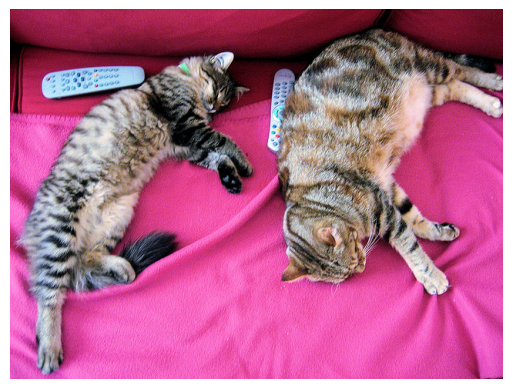

In [8]:
plt.imshow(image)
plt.axis("off")

In [9]:
image_inputs = processor([image], return_tensors="pt")

In [10]:
image_inputs["pixel_values"]

tensor([[[[ 0.5873,  0.5873,  0.6165,  ...,  0.0617,  0.0471, -0.0259],
          [ 0.5727,  0.5727,  0.6603,  ...,  0.1201,  0.0763,  0.0909],
          [ 0.5873,  0.5435,  0.6165,  ...,  0.0325,  0.1201,  0.0617],
          ...,
          [ 1.8719,  1.8573,  1.8719,  ...,  1.3902,  1.4340,  1.4194],
          [ 1.8281,  1.8719,  1.8427,  ...,  1.4486,  1.4340,  1.5070],
          [ 1.8573,  1.9011,  1.8281,  ...,  1.3756,  1.3610,  1.4486]],

         [[-1.3169, -1.3019, -1.3169,  ..., -1.4970, -1.4369, -1.4820],
          [-1.2418, -1.2718, -1.2268,  ..., -1.4369, -1.4669, -1.4519],
          [-1.2568, -1.3169, -1.2268,  ..., -1.4669, -1.4069, -1.4519],
          ...,
          [ 0.1239,  0.1089,  0.1239,  ..., -0.7016, -0.6865, -0.6865],
          [ 0.0789,  0.0939,  0.0488,  ..., -0.6565, -0.6865, -0.6115],
          [ 0.0939,  0.1089,  0.0038,  ..., -0.7766, -0.7316, -0.6115]],

         [[-0.4848, -0.4137, -0.3853,  ..., -0.9541, -0.8545, -0.8545],
          [-0.4137, -0.4706, -

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 223.5, 223.5, -0.5)

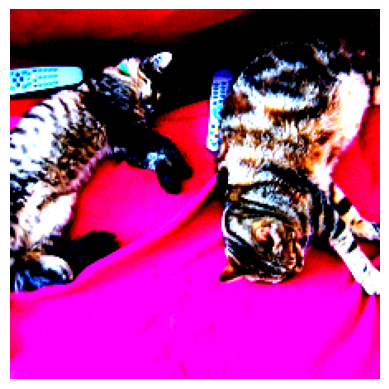

In [11]:
plt.imshow(image_inputs["pixel_values"].squeeze().transpose(0,2).transpose(0,1))
plt.axis("off")

In [12]:
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

In [13]:
# TODO have these generated by the transformer from previous lab
texts=["a photo of a cat", "a photo of a dog", "a photo of a car"]
text_inputs=tokenizer(texts, return_tensors="pt", truncation=True, padding="longest")

In [14]:
for k,v in text_inputs.items():
    text_inputs[k]=v.to(model.device)

In [15]:
for k,v in image_inputs.items():
    image_inputs[k]=v.to(model.device)

In [16]:
text_embedding = model.text_model(**text_inputs).pooler_output

In [17]:
pixel_values = image_inputs["pixel_values"]
batch_size, _, height, width = pixel_values.shape
target_dtype = model.vision_model.embeddings.patch_embedding.weight.dtype
patch_embeds = model.vision_model.embeddings.patch_embedding(pixel_values.to(dtype=target_dtype))  # shape = [*, width, grid, grid]
patch_embed_flat = patch_embeds.flatten(2).transpose(1, 2)

class_embeds = model.vision_model.embeddings.class_embedding.expand(batch_size, 1, -1)
hidden_states = torch.cat([class_embeds, patch_embed_flat], dim=1)
hidden_states = hidden_states + model.vision_model.embeddings.position_embedding(model.vision_model.embeddings.position_ids)

# this does it in one line
#hidden_states = model.vision_model.embeddings(image_inputs["pixel_values"])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

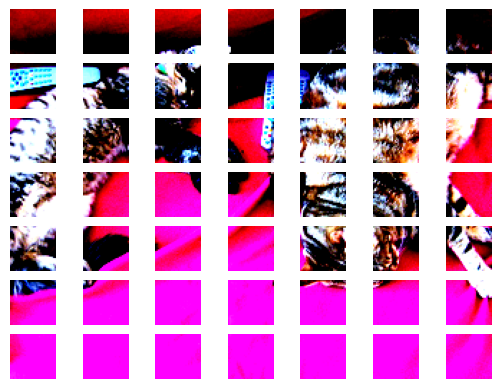

In [42]:
assert height==width
patch_size=model.vision_model.embeddings.patch_size
num_patches = width//patch_size
fig,axes = plt.subplots(num_patches, num_patches)
image_to_plot = pixel_values[0].transpose(0,2).transpose(0,1).cpu()
for i in range(num_patches):
    for j in range(num_patches):
        axes[i,j].imshow(image_to_plot[i*patch_size:(i+1)*patch_size,j*patch_size:(j+1)*patch_size])
        axes[i,j].axis("off")

In [51]:
manual_conv = torch.zeros(num_patches, num_patches,device=model.device)
for i in range(num_patches):
    for j in range(num_patches):
        manual_conv[i,j]=(pixel_values[0,:,i*patch_size:(i+1)*patch_size,j*patch_size:(j+1)*patch_size]*model.vision_model.embeddings.patch_embedding.weight[0]).sum()
   # print()

In [58]:
assert torch.isclose(manual_conv,patch_embeds[0,0],atol=1e-6).all()

In [49]:
manual_conv

tensor([[ 0.1563,  0.2167,  0.0700,  0.2983, -0.0587,  0.4001, -0.1399],
        [-1.1652,  1.0278,  1.0702,  0.0928, -0.1709, -0.5842,  0.1128],
        [ 0.8221,  0.0252,  0.6142,  0.9892,  0.2489,  0.4761,  1.0463],
        [-0.4725,  0.7867,  0.1147, -0.9602,  0.3285, -0.5464, -0.0221],
        [ 0.1366, -0.0588,  0.3622,  0.3515,  0.0789, -0.3064, -0.6587],
        [ 0.4915,  0.0873,  0.4238,  0.2976,  0.0313,  0.4432,  0.2797],
        [ 0.1370,  0.2782,  0.3487,  0.4768,  0.2954,  0.3028,  0.3478]])

In [44]:
patch_embeds[0,0]

tensor([[ 0.1563,  0.2167,  0.0700,  0.2983, -0.0587,  0.4001, -0.1399],
        [-1.1652,  1.0278,  1.0702,  0.0928, -0.1709, -0.5842,  0.1128],
        [ 0.8221,  0.0252,  0.6142,  0.9892,  0.2489,  0.4761,  1.0463],
        [-0.4725,  0.7867,  0.1147, -0.9602,  0.3285, -0.5464, -0.0221],
        [ 0.1366, -0.0588,  0.3622,  0.3515,  0.0789, -0.3064, -0.6587],
        [ 0.4915,  0.0873,  0.4238,  0.2976,  0.0313,  0.4432,  0.2797],
        [ 0.1370,  0.2782,  0.3487,  0.4768,  0.2954,  0.3028,  0.3478]],
       device='cuda:0')

In [18]:
hidden_states = model.vision_model.pre_layrnorm(hidden_states)

encoder_outputs = model.vision_model.encoder(
    inputs_embeds=hidden_states
)

last_hidden_state = encoder_outputs.last_hidden_state
pooled_output = last_hidden_state[:, 0, :]
image_embedding = model.vision_model.post_layernorm(pooled_output)

# this does it in one line
#image_embedding = model.vision_model(**image_inputs).pooler_output

In [19]:
text_embedding = model.text_projection(text_embedding)

In [20]:
image_embedding = model.visual_projection(image_embedding)

In [21]:
text_embedding/=text_embedding.norm(dim=1, keepdim=True)
image_embedding/=image_embedding.norm(dim=1, keepdim=True)

In [22]:
similarities = image_embedding@text_embedding.T

In [23]:
ranking = similarities.argsort(dim=1, descending=True)

In [24]:
assert ranking.shape[0] == 1
for i in ranking[0]:
    print(f"{texts[i.item()]} - {similarities[0,i].item():.3f}")

a photo of a cat - 0.246
a photo of a dog - 0.193
a photo of a car - 0.185
